In [1]:
"""
Student Attendance System - Assignment 2
Simple CNN with OpenCV Camera
"""

'\nStudent Attendance System - Assignment 2\nSimple CNN with OpenCV Camera\n'

In [2]:
!pip install tensorflow opencv-python numpy==1.26.4 matplotlib seaborn scikit-learn gdown -q

In [3]:
# Cell: Download Dataset from Google Drive
import gdown
import os

# Google Drive file ID
FILE_ID = "1c6c6Ogw82xNSON6sDtwdXv2VMI1-C4uD"
OUTPUT_FILE = "preprocessed_faces.npz"

if not os.path.exists(OUTPUT_FILE):
    print("Downloading dataset from Google Drive...")
    url = f"https://drive.google.com/uc?id={FILE_ID}"
    gdown.download(url, OUTPUT_FILE, quiet=False)
    print(f"✓ Downloaded: {OUTPUT_FILE}")
else:
    print(f"✓ Dataset already exists: {OUTPUT_FILE}")

✓ Dataset already exists: preprocessed_faces.npz


In [4]:
# Cell 1: Imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

c:\Users\aonye\anaconda3\envs\newspaper_test\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [5]:
# Cell 2: Configuration
IMG_SIZE = 96
BATCH_SIZE = 16
EPOCHS = 50
MIN_CONFIDENCE = 0.85  # 85% threshold to reduce false positives

# ========== LOAD MODEL ONLY MODE ==========
LOAD_MODEL_ONLY = False  # Change to True after training once
# ==========================================

BASE_DIR = Path(__file__).parent.absolute() if '__file__' in dir() else Path('.').absolute()
MODEL_DIR = BASE_DIR / 'models'
MODEL_DIR.mkdir(exist_ok=True)
SAVED_MODEL_PATH = MODEL_DIR / 'cnn_model.keras'

print("=" * 50)
print("Student Attendance System")
print(f"LOAD_MODEL_ONLY = {LOAD_MODEL_ONLY}")
print("=" * 50)

Student Attendance System
LOAD_MODEL_ONLY = False


In [6]:
# Cell 3: Load Data from NPZ
print("\nLoading data...")
data = np.load(BASE_DIR / 'preprocessed_faces.npz', allow_pickle=True)
X_raw = data['X']
y = data['y']
CLASS_NAMES = list(data['class_names'])
NUM_CLASSES = len(CLASS_NAMES)

# Resize and normalize to [0, 1]
X = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_raw], dtype=np.float32) / 255.0
print(f"✓ Loaded {len(X)} images, {NUM_CLASSES} classes")
print(f"  Data range: {X.min():.2f} to {X.max():.2f}")

# IMPORTANT: Shuffle data to prevent mode collapse
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]
print("✓ Data shuffled")


Loading data...
✓ Loaded 1319 images, 66 classes
  Data range: 0.00 to 1.00
✓ Data shuffled


In [7]:
# Cell 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 1055, Test: 264


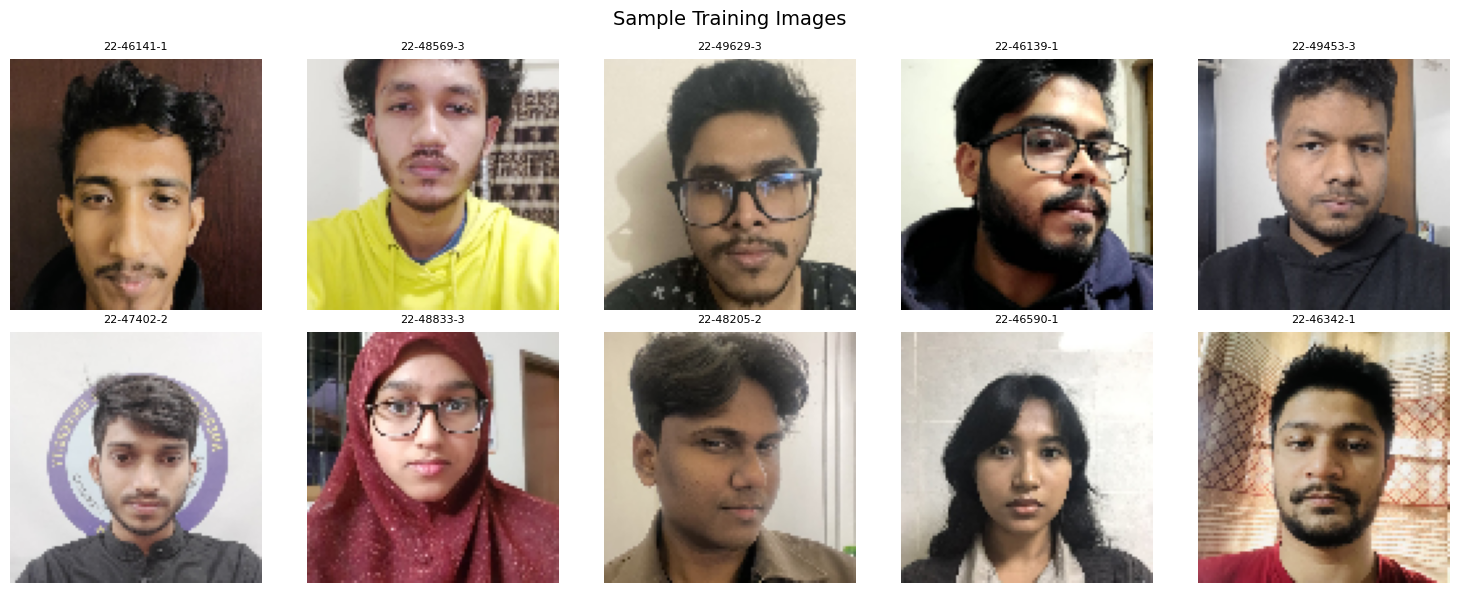

In [8]:
# Cell 5: Visualize Sample Data
plt.figure(figsize=(15, 6))
for i in range(min(10, len(X_train))):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(CLASS_NAMES[y_train[i]][:12], fontsize=8)
    plt.axis('off')
plt.suptitle('Sample Training Images', fontsize=14)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'sample_images.png')
plt.show()

In [9]:
# Cell 6: Build or Load Model (Simplified to prevent mode collapse)
if LOAD_MODEL_ONLY and SAVED_MODEL_PATH.exists():
    print(f"\n✓ Loading saved model: {SAVED_MODEL_PATH}")
    from tensorflow.keras.models import load_model
    model = load_model(SAVED_MODEL_PATH)
    print("✓ Model loaded successfully!")
else:
    # Simpler model that won't collapse
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    # Lower learning rate to prevent mode collapse
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

c:\Users\aonye\anaconda3\envs\newspaper_test\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 66)             │        16,962 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,954 (18.42 MB)

 Trainable params: 4,829,506 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.0171 - loss: 6.2088 - val_accuracy: 0.0152 - val_loss: 4.2196 - learning_rate: 1.0000e-04
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.0265 - loss: 6.0189 - val_accuracy: 0.0152 - val_loss: 4.3251 - learning_rate: 1.0000e-04
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.0246 - loss: 5.8203 - val_accuracy: 0.0076 - val_loss: 5.0439 - learning_rate: 1.0000e-04
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.0294 - loss: 5.5141 - val_accuracy: 0.0189 - val_loss: 6.1048 - learning_rate: 1.0000e-04
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.0294 - loss: 5.5133 - val_accuracy: 0.0152 - val_loss: 10.7058 - learning_rate: 5.0000e-05
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.0332 - loss: 5.3597 - val_accuracy: 0.0152 - val_loss: 16.2291 - learning_rate: 5.0000e-05

✓ Model saved to: c:\Users\aonye\Documents\NitPaul\10th semes

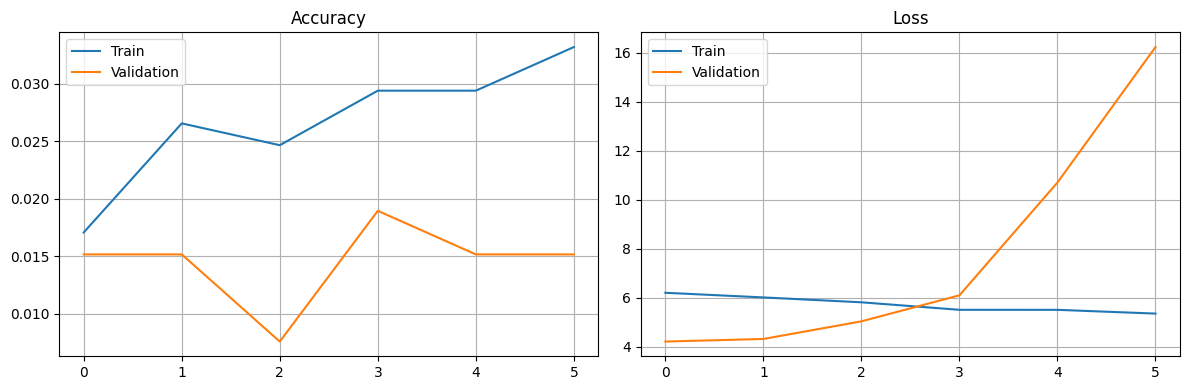

In [10]:
# Cell 7-9: Training (skipped if LOAD_MODEL_ONLY=True)
if not LOAD_MODEL_ONLY:
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
    
    history = model.fit(
        train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test_cat),
        callbacks=callbacks
    )
    
    model.save(SAVED_MODEL_PATH)
    print(f"\n✓ Model saved to: {SAVED_MODEL_PATH}")
    
    # Training History
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(MODEL_DIR / 'training_history.png')
    plt.show()
else:
    print("\n✓ LOAD_MODEL_ONLY=True: Skipping training, using saved model")

In [11]:
# Cell 10: Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {accuracy:.1%}")

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
y_pred_conf = np.max(model.predict(X_test, verbose=0), axis=1)

# High confidence accuracy
high_conf_mask = y_pred_conf >= MIN_CONFIDENCE
if high_conf_mask.sum() > 0:
    high_conf_acc = (y_pred[high_conf_mask] == y_test[high_conf_mask]).mean()
    print(f"High Confidence (≥{MIN_CONFIDENCE:.0%}) Accuracy: {high_conf_acc:.1%}")


Test Accuracy: 1.5%


In [12]:
# Cell 11: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

  21-45902-3       0.00      0.00      0.00         4
  22-46138-1       0.00      0.00      0.00         4
  22-46139-1       0.00      0.00      0.00         4
  22-46141-1       0.00      0.00      0.00         4
  22-46275-1       0.00      0.00      0.00         4
  22-46293-1       0.00      0.00      0.00         4
  22-46342-1       0.00      0.00      0.00         4
  22-46473-1       0.00      0.00      0.00         4
  22-46536-1       0.00      0.00      0.00         4
  22-46590-1       0.00      0.00      0.00         4
  22-46666-1       0.00      0.00      0.00         4
  22-46679-1       0.00      0.00      0.00         4
  22-46887-1       0.00      0.00      0.00         4
  22-46945-1       0.00      0.00      0.00         4
  22-46983-1       0.00      0.00      0.00         4
  22-47180-1       0.00      0.00      0.00         4
  22-47294-1       0.00      0.00      0.00         4
  2

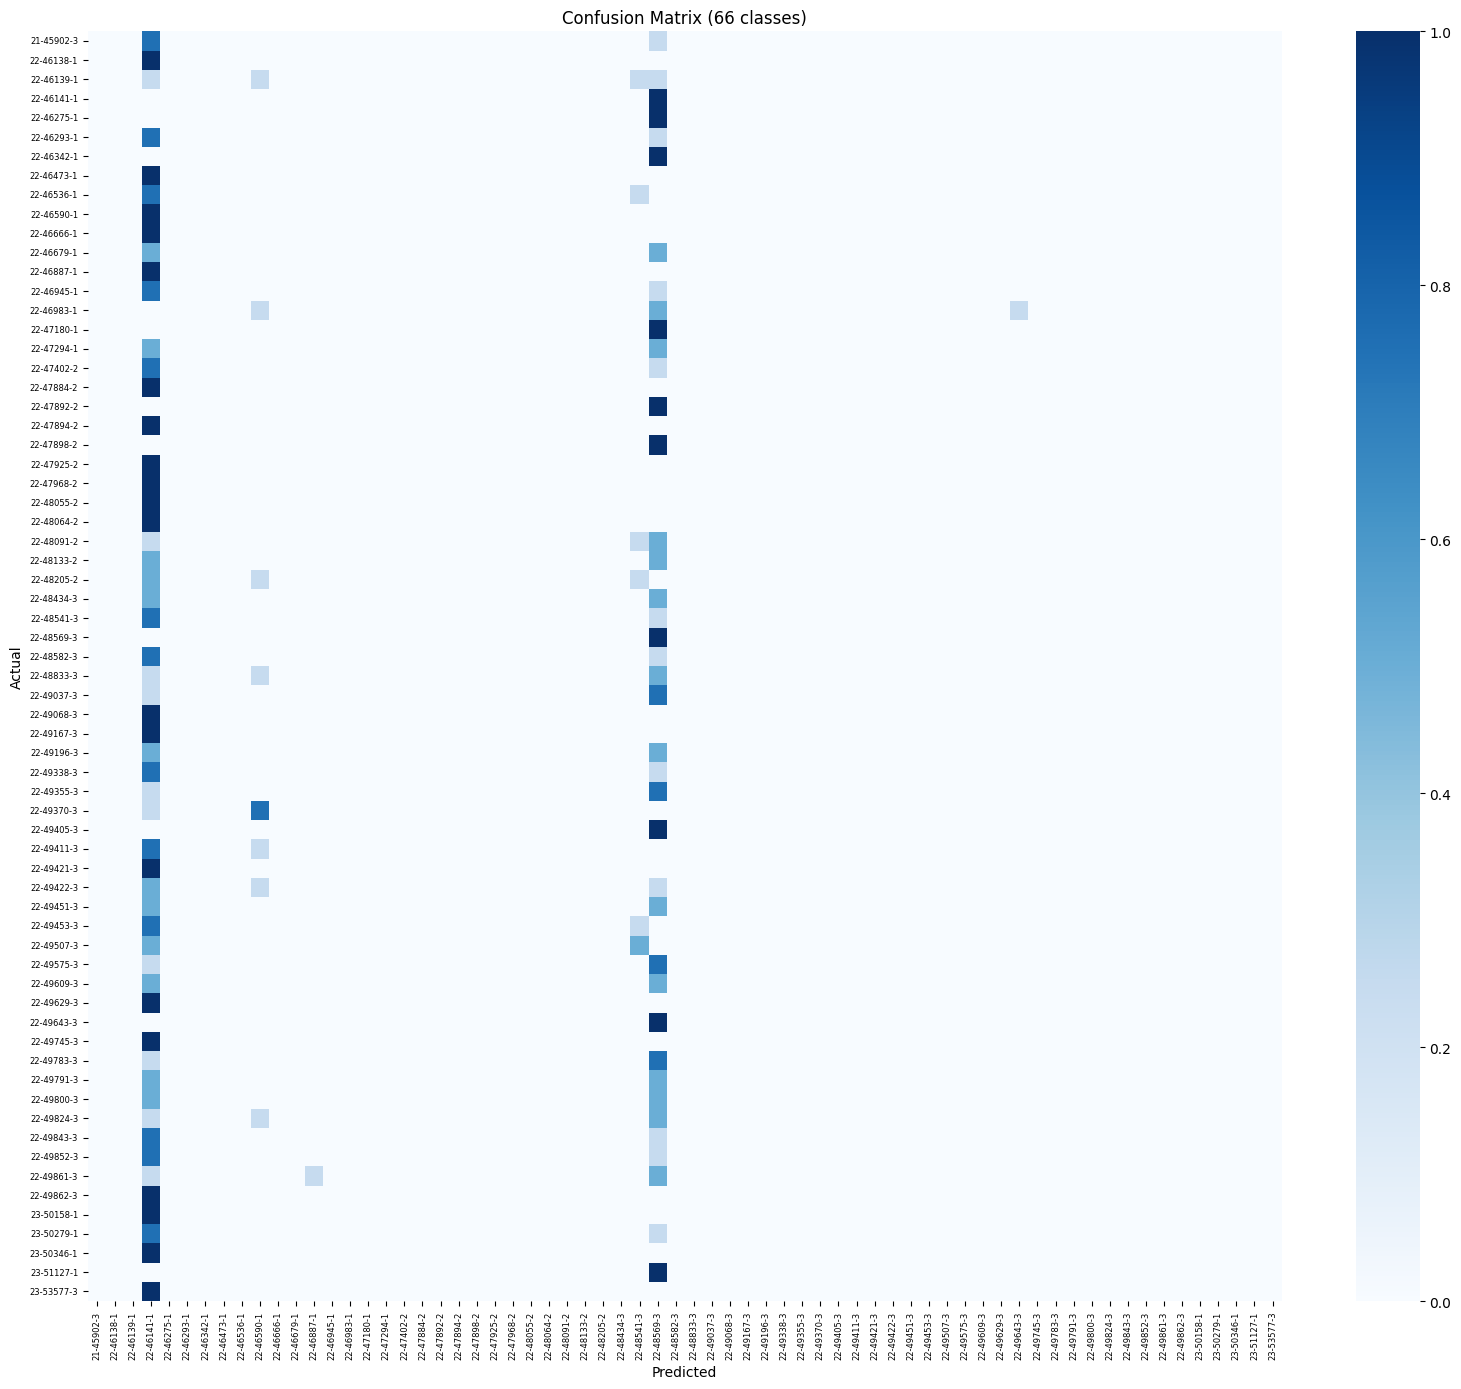

In [13]:
# Cell 12: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 
            annot=False, cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix ({NUM_CLASSES} classes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'confusion_matrix.png', dpi=150)
plt.show()

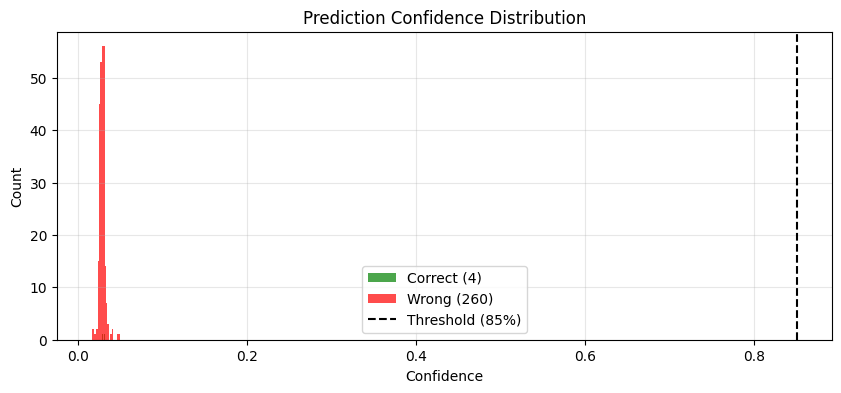

In [14]:
# Cell 13: Confidence Distribution
plt.figure(figsize=(10, 4))
correct = y_pred == y_test
plt.hist(y_pred_conf[correct], bins=20, alpha=0.7, label=f'Correct ({correct.sum()})', color='green')
plt.hist(y_pred_conf[~correct], bins=20, alpha=0.7, label=f'Wrong ({(~correct).sum()})', color='red')
plt.axvline(MIN_CONFIDENCE, color='black', linestyle='--', label=f'Threshold ({MIN_CONFIDENCE:.0%})')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Prediction Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(MODEL_DIR / 'confidence_distribution.png')
plt.show()

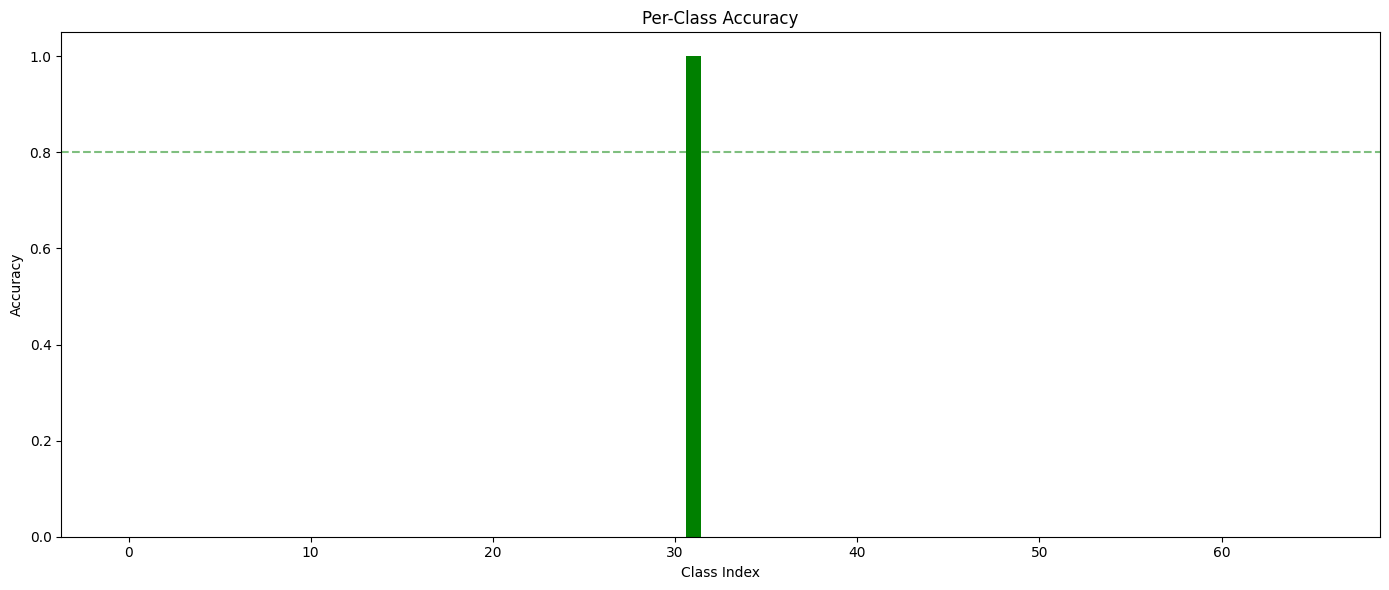

In [15]:
# Cell 14: Per-Class Accuracy
per_class_acc = []
for i in range(NUM_CLASSES):
    mask = y_test == i
    if mask.sum() > 0:
        per_class_acc.append((y_pred[mask] == i).mean())
    else:
        per_class_acc.append(0)

plt.figure(figsize=(14, 6))
colors = ['green' if acc >= 0.8 else 'orange' if acc >= 0.5 else 'red' for acc in per_class_acc]
plt.bar(range(NUM_CLASSES), per_class_acc, color=colors)
plt.axhline(0.8, color='green', linestyle='--', alpha=0.5)
plt.xlabel('Class Index')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'per_class_accuracy.png')
plt.show()

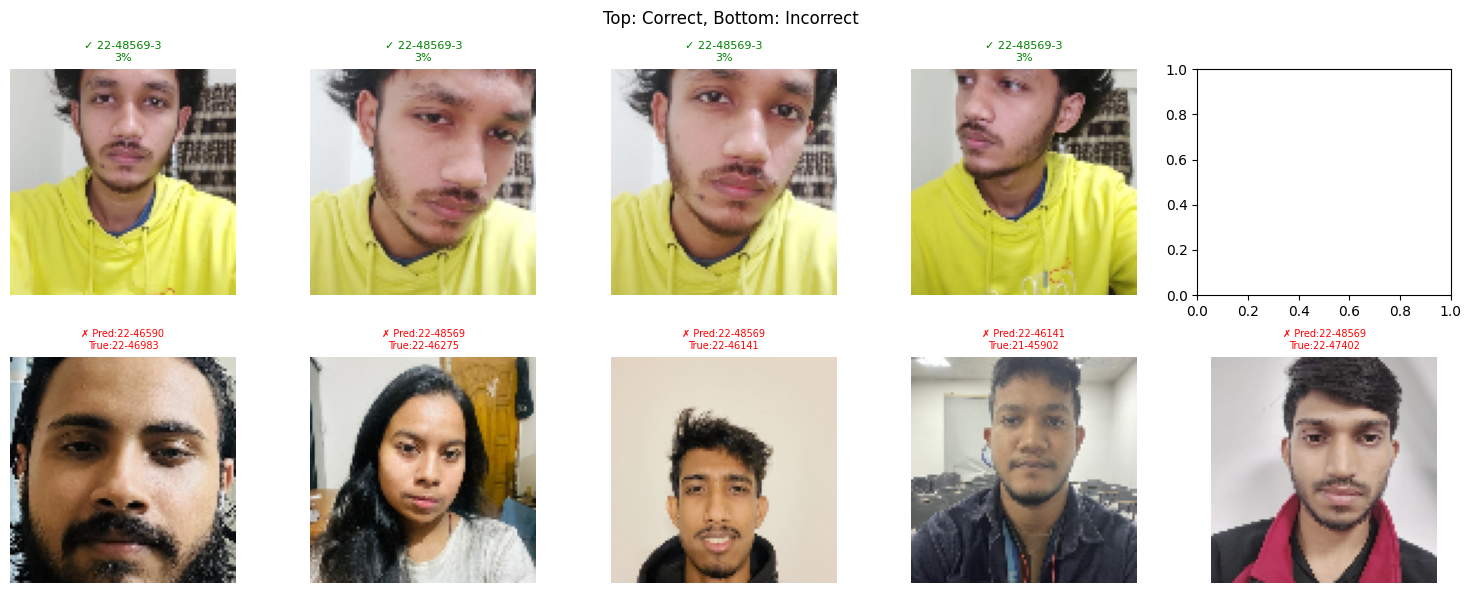

In [16]:
# Cell 15: Sample Predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
correct_idx = np.where(correct)[0][:5]
wrong_idx = np.where(~correct)[0][:5]

for i, idx in enumerate(correct_idx):
    axes[0, i].imshow(X_test[idx])
    axes[0, i].set_title(f'✓ {CLASS_NAMES[y_test[idx]][:10]}\n{y_pred_conf[idx]:.0%}', color='green', fontsize=8)
    axes[0, i].axis('off')

for i, idx in enumerate(wrong_idx):
    if i < len(wrong_idx):
        axes[1, i].imshow(X_test[idx])
        axes[1, i].set_title(f'✗ Pred:{CLASS_NAMES[y_pred[idx]][:8]}\nTrue:{CLASS_NAMES[y_test[idx]][:8]}', color='red', fontsize=7)
        axes[1, i].axis('off')

plt.suptitle('Top: Correct, Bottom: Incorrect')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'sample_predictions.png')
plt.show()

In [17]:
# Cell 16: Camera Attendance
print("\n" + "=" * 50)
print("CAMERA ATTENDANCE")
print("Press 'q' to quit")
print("=" * 50)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
attendance = {}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        
        pred = model.predict(np.expand_dims(face, 0), verbose=0)[0]
        idx, conf = np.argmax(pred), np.max(pred)
        name = CLASS_NAMES[idx] if conf >= MIN_CONFIDENCE else f"Unknown ({CLASS_NAMES[idx]}?)"
        
        if conf >= MIN_CONFIDENCE and name not in attendance:
            attendance[name] = datetime.now()
            print(f"✓ {name} present ({conf:.0%})")
        
        color = (0, 255, 0) if conf >= MIN_CONFIDENCE else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, f"{name}: {conf:.0%}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    cv2.putText(frame, f"Present: {len(attendance)}/{NUM_CLASSES}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.imshow('Attendance', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print(f"\nTotal: {len(attendance)}/{NUM_CLASSES} present")


CAMERA ATTENDANCE
Press 'q' to quit

Total: 0/66 present
